# Gaussian Process Distribution of Relaxation Times. 
### Reproduce Figure 8 in the main context

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import GP_DRT
import importlib
from scipy.optimize import minimize
%matplotlib inline
# importlib.reload(GP_DRT)

#### Define parameters for the synthetic EIS, which is generated with a ZARC model

In [13]:
# define frequency range
N_freqs = 71
freq_vec = np.logspace(-3., 4., num=N_freqs, endpoint=True)
xi_vec = np.log(freq_vec)
tau  = 1/freq_vec

# define frequency range used for prediction
freq_vec_star = np.logspace(-4., 4., num=81, endpoint=True)
xi_vec_star = np.log(freq_vec_star)

# define variables for exact
R_inf = 10
R_ct = 50
phi = 0.8
tau_0 = 1.

T = tau_0**phi/R_ct
Z_exact = R_inf+1./(1./R_ct+T*(1j*2.*pi*freq_vec)**phi)
gamma_fct = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau/tau_0))-cos((1.-phi)*pi))

# used for plotting only
freq_vec_plot  = np.logspace(-4., 4., num=10*(N_freqs-1), endpoint=True)
tau_plot  = 1/freq_vec_plot
gamma_fct_plot = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_plot/tau_0))-cos((1.-phi)*pi)) # for plotting only

# random
rng = np.random.seed(214974)
sigma_n_exp = 0.1
Z_exp = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

#### show the synthetic impedance in Nyquist plot, as shown in Figure 7 (a)

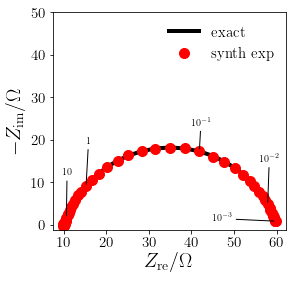

In [14]:
fig, ax = plt.subplots()
plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color="black", label="exact")
plt.plot(np.real(Z_exp), -np.imag(Z_exp), "o", markersize=10, color="red", label="synth exp")
plt.annotate(r'$10^{-3}$', xy=(np.real(Z_exp[0]), -np.imag(Z_exp[0])), 
             xytext=(np.real(Z_exp[0])-15, -np.imag(Z_exp[0])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[10]), -np.imag(Z_exp[10])), 
             xytext=(np.real(Z_exp[10])-2, 10-np.imag(Z_exp[10])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10^{-1}$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
             xytext=(np.real(Z_exp[20])-2, 6-np.imag(Z_exp[20])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$1$', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
             xytext=(np.real(Z_exp[30]), 10-np.imag(Z_exp[30])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10$', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
             xytext=(np.real(Z_exp[40])-1, 10-np.imag(Z_exp[40])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 60, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()

#### running the GP-DRT model to get the optimal hyperparameters

In [15]:
# run the NMLL minimization in 3D
sigma_n = sigma_n_exp
sigma_f = 5.
ell = 1.

theta_0 = np.array([sigma_n, sigma_f, ell])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print(theta[0], theta[1], theta[2])
    
GP_DRT.NMLL_fct(theta_0, Z_exp, xi_vec)
GP_DRT.grad_NMLL_fct(theta_0, Z_exp, xi_vec)

res = minimize(GP_DRT.NMLL_fct, theta_0, args=(Z_exp, xi_vec), method='Newton-CG', \
               jac=GP_DRT.grad_NMLL_fct,  callback=print_results, options={'disp': True})

0.10500942751000038 5.000109746006856 0.9994336625270901
0.10481007799165244 5.010790331601916 0.948165784086906
0.10473024461535729 5.030622566031582 0.8953988100548943
0.10475540456123235 5.2374445168389085 0.9106820030007828
0.10472350953052488 5.67621267509251 0.9283941869990576
0.10472612810307784 5.795425524626024 0.9351817840708904
0.10472993819580781 5.795426125264269 0.9351819281462721
Optimization terminated successfully.
         Current function value: -68.171892
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 44
         Hessian evaluations: 0


In [16]:
# write up the results of optimization into the parameters needed for deconvolution
sigma_n, sigma_f, ell = res.x

K = GP_DRT.matrix_K(xi_vec, xi_vec, sigma_f, ell)
L_im_K = GP_DRT.matrix_L_im_K(xi_vec, xi_vec, sigma_f, ell)
L2_im_K = GP_DRT.matrix_L2_im_K(xi_vec, xi_vec, sigma_f, ell)
Sigma = (sigma_n**2)*np.eye(N_freqs)

K_im_full = L2_im_K + Sigma

# cholesky factorization
L = np.linalg.cholesky(K_im_full)

# solve for alpha
alpha = np.linalg.solve(L, Z_exp.imag)
alpha = np.linalg.solve(L.T, alpha)

# estimate the gamma
gamma_fct_est = -np.dot(L_im_K.T, alpha)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_im_full = np.dot(inv_L.T, inv_L)
inv_K_im_full2 = np.linalg.inv(K_im_full)
np.diag(np.dot(inv_K_im_full, K_im_full))

cov_gamma_fct_est = K - np.dot(L_im_K.T, np.dot(inv_K_im_full, L_im_K))
sigma_gamma_fct_est = np.sqrt(np.diag(cov_gamma_fct_est))

#### calcualte the covariance matrix to get the prediction on DRT and impedance

In [17]:
Z_im_vec_star = np.empty_like(xi_vec_star)
Sigma_Z_im_vec_star = np.empty_like(xi_vec_star)

gamma_vec_star = np.empty_like(xi_vec_star)
Sigma_gamma_vec_star = np.empty_like(xi_vec_star)

for index, val in enumerate(xi_vec_star):

    # prediction log(freq)
    xi_star = np.array([val])

    # compute base vectors
    k_star = GP_DRT.matrix_K(xi_vec, xi_star, sigma_f, ell)
    L_im_k_star = GP_DRT.matrix_L_im_K(xi_vec, xi_star, sigma_f, ell) #; L_im_k_star = L_im_k_star.T
    L2_im_k_star = GP_DRT.matrix_L2_im_K(xi_star, xi_vec, sigma_f, ell); L2_im_k_star= L2_im_k_star.T
    k_star_star = GP_DRT.matrix_K(xi_star, xi_star, sigma_f, ell)
    L_im_k_star_star = GP_DRT.matrix_L_im_K(xi_star, xi_star, sigma_f, ell)
    L2_im_k_star_star = GP_DRT.matrix_L2_im_K(xi_star, xi_star, sigma_f, ell)

    # compute Z_im_star mean and standard deviation
    Z_im_vec_star[index] = np.dot(L2_im_k_star.T,np.dot(inv_K_im_full,Z_exp.imag))
    Sigma_Z_im_vec_star[index] = L2_im_k_star_star-np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, L2_im_k_star))
    
    # compute Z_im_star mean and standard deviation
    gamma_vec_star[index] = -np.dot(L_im_k_star.T,np.dot(inv_K_im_full,Z_exp.imag))
    Sigma_gamma_vec_star[index] = k_star_star-np.dot(L_im_k_star.T, np.dot(inv_K_im_full, L_im_k_star))


#### plot the DRT

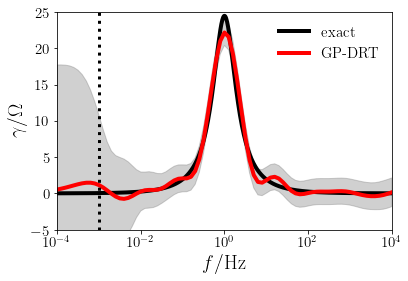

In [18]:
# plot of the DRT
plt.semilogx(freq_vec_plot, gamma_fct_plot, linewidth=4, color="black", label="exact")
plt.semilogx(freq_vec_star, gamma_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.semilogx([1E-3, 1E-3], [-5, 25], ':', linewidth=3, color="black")
plt.fill_between(freq_vec_star, gamma_vec_star-3*np.sqrt(abs(Sigma_gamma_vec_star)), gamma_vec_star+3*np.sqrt(abs(Sigma_gamma_vec_star)), color="0.4", alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
plt.show()

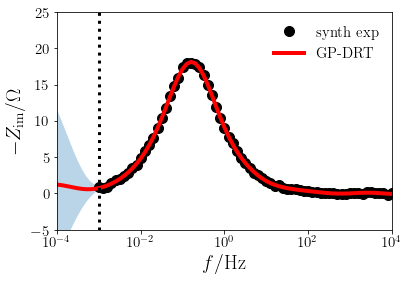

In [19]:
plt.semilogx(freq_vec, -Z_exp.imag, "o", markersize=10, color="black", label="synth exp")
plt.semilogx(freq_vec_star, -Z_im_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.semilogx([1E-3, 1E-3], [-5, 25], ':', linewidth=3, color="black")
plt.fill_between(freq_vec_star, -Z_im_vec_star-3*np.sqrt(abs(Sigma_Z_im_vec_star)), -Z_im_vec_star+3*np.sqrt(abs(Sigma_Z_im_vec_star)), alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()